In [71]:
import os
import glob
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
#helper methods
def drop_null_columns(df):
    nulls_list = []

    for col in df:
        percent_null = df[col].isnull().sum() / len(df[col])
        if percent_null > 0.3333:
            nulls_list.append(col)
            print(f"Dropping {col}")
            
    df.drop(columns=nulls_list, inplace=True)
    
    return df

def is_tats(df_col):
    return re.search("tat_", df_col)

def is_dttm(df_col):
    return re.search("_DTTM", df_col)

def parse_timestamp(df):
    #ins
    df['TRANSFER_REQUEST_DTTM'] = pd.to_datetime(df['TRANSFER_REQUEST_DTTM'])
    df['hour_of_day_in'] = df.apply(lambda row: row['TRANSFER_REQUEST_DTTM'].hour, axis=1)
    df['day_of_week_in'] = df.apply(lambda row: row['TRANSFER_REQUEST_DTTM'].weekday(), axis=1)

    
    #outs
    df['TRANSFER_COMPLETE_DTTM'] = pd.to_datetime(df['TRANSFER_COMPLETE_DTTM'])
    df['hour_of_day_out'] = df.apply(lambda row: row['TRANSFER_COMPLETE_DTTM'].hour, axis=1)
    df['day_of_week_out'] = df.apply(lambda row: row['TRANSFER_COMPLETE_DTTM'].weekday(), axis=1)

    return df

def drop_canceled(df):
    return df[~(df["TRANSFER_MILESTONE_STATE"] == 'Canceled')].reset_index(inplace=True, drop=True)

def read_files():
    data_dir = '/home/cgomez/Pegasus/CAP_mgmt/data'
    os.chdir(data_dir)
    all_files = glob.glob('*.{}'.format('csv'))

    flow_files = []

    for file in all_files:
        if re.search("Flow", file):
            flow_files.append(file)
    flow_df = pd.concat((pd.read_csv(filename) for filename in flow_files))

    evs_files = []

    for file in all_files:
        if re.search("EVS_LastXDays", file):
            evs_files.append(file)

    evs_df = pd.concat((pd.read_csv(filename) for filename in evs_files))

    preadmit_files = []

    for file in all_files:
        if re.search("Preadmit", file):
            preadmit_files.append(file)

    preadmit_df = pd.concat((pd.read_csv(filename) for filename in preadmit_files))
    
    return flow_df, evs_df, preadmit_df

def calc_time_diffs(df, col1, col2):
    return (pd.to_datetime(df[col2]) - pd.to_datetime(df[col1])).dt.total_seconds()/3600

def aggregate_dataframe(df, col, val):
    aggregate_df = df.groupby(col).aggregate({val: ['min', 'max', 'mean'], "NEW_ORDER_ID": ['count']}).sort_values(("NEW_ORDER_ID", "count"), ascending=False).reset_index()
    
    return aggregate_df

def add_origin_to_dest(df):
    df['origin to destination unit'] = np.nan
        
    for ix in range(len(df.index)):
        try:
            df['origin to destination unit'].iloc[ix] = "{} to {}".format(df['ORIGIN_LOC_UNIT_DISP'].iloc[ix], 
                                                                        df['DEST_LOC_UNIT_DISP'].iloc[ix])
        except:
            print(f"Exception on {ix}")
    return df

def get_ORDER_ID(df):
    df['NEW_ORDER_ID'] = np.nan
    df = df[df['ORDER_ID'].isnull() == False]
    #df = df.reset_index(drop=True, inplace=True)
    
    for ix in range(len(df.index)):
        df['NEW_ORDER_ID'].iloc[ix] = df['ORDER_ID'].iloc[ix].split("urn:cerner:mid:orders.order:p19.jack_fl.cernerasp.com:")[1]
    return df


def run_pandas_profiling(df, title):
    profile = ProfileReport(df)
    return profile.to_file(title)

In [73]:
flow_df, evs_df, preadmit_df = read_files()


/tmp/ipykernel_85245/1071785115.py:48: DtypeWarning: Columns (23,58) have mixed types. Specify dtype option on import or set low_memory=False.
  flow_df = pd.concat((pd.read_csv(filename) for filename in flow_files))
/tmp/ipykernel_85245/1071785115.py:56: DtypeWarning: Columns (11,13,17,18,39) have mixed types. Specify dtype option on import or set low_memory=False.
  evs_df = pd.concat((pd.read_csv(filename) for filename in evs_files))
/tmp/ipykernel_85245/1071785115.py:56: DtypeWarning: Columns (11,13,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  evs_df = pd.concat((pd.read_csv(filename) for filename in evs_files))
/tmp/ipykernel_85245/1071785115.py:64: DtypeWarning: Columns (9,34) have mixed types. Specify dtype option on import or set low_memory=False.
  preadmit_df = pd.concat((pd.read_csv(filename) for filename in preadmit_files))


In [74]:
flow_df['ORIGIN_LOC_INSTITUTION_DISP'].unique()

array(['Jackson South Community Hospital', 'Jackson North Medical Center',
       'Jackson Memorial Hospital', 'Jackson West Medical Center',
       "Holtz Children's Hospital", 'Jackson Behavioral Health Hospital',
       "Women's Hospital at Jackson Memorial",
       'Jackson South Behavioral Health'], dtype=object)

In [75]:
memorial_df = flow_df[(flow_df['ORIGIN_LOC_INSTITUTION_DISP'] == 
                      'Jackson Memorial Hospital')]
memorial_df.reset_index(drop=True, inplace=True)
memorial_df.shape

(41519, 95)

In [76]:
memorial_df = get_ORDER_ID(memorial_df)

/tmp/ipykernel_85245/1071785115.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NEW_ORDER_ID'] = np.nan
/tmp/ipykernel_85245/1071785115.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NEW_ORDER_ID'].iloc[ix] = df['ORDER_ID'].iloc[ix].split("urn:cerner:mid:orders.order:p19.jack_fl.cernerasp.com:")[1]


In [77]:
memorial_df.NEW_ORDER_ID.isnull().sum()

0

In [78]:
memorial_df.drop_duplicates(subset=['MRN', 'FIN', 'NEW_ORDER_ID'], inplace=True)


In [79]:
memorial_df = memorial_df[(memorial_df['TRANSFER_MILESTONE_STATE'] == 
                      "Completed")]
memorial_df.reset_index(drop=True, inplace=True)

In [81]:
add_origin_to_dest(memorial_df)
parse_timestamp(memorial_df)

memorial_df['discharge(actual - estimated)'] = calc_time_diffs(memorial_df, 'ESTIMATED_DEPART_DTTM', 
                                                           'DISCHARGE_DTTM')

memorial_df['bed_avail_to_transfer_request'] = calc_time_diffs(memorial_df, 'DEST_LOC_BED_AVAIL_BEGIN_DTTM', 
                                                           'TRANSFER_REQUEST_DTTM')

memorial_df['transfer_request_to_transfer_start'] = calc_time_diffs(memorial_df,'TRANSFER_REQUEST_DTTM',
                                                               'TRANSFER_START_DTTM')

/tmp/ipykernel_85245/1071785115.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['origin to destination unit'].iloc[ix] = "{} to {}".format(df['ORIGIN_LOC_UNIT_DISP'].iloc[ix],


In [82]:
memorial_df.drop(columns=['FIN', 'MRN','ENCOUNTER_ID',
       'ENCNTR_ID', 'PREVIOUS_ENCNTR_ID', 'PREVIOUS_FIN', 'PREVIOUS_MRN',
       'PATIENT_NAME'], inplace=True)

In [83]:
cols_to_drop = ['TRANSPORTER', 'CURR_LOC_INSTITUTION_DISP',
                'CURR_LOC_BUILDING_DISP', 'CURR_LOC_UNIT_DISP',
                'CURR_LOC_ROOM_DISP', 'CURR_LOC_BED_DISP',
                'TRANSFER_MILESTONE_ID', 'TRANSFER_MILESTONE_STATE',
                'STATUS', 'ORIGIN_LOC_INSTITUTION_DISP', 'ORIGIN_LOC_BUILDING_DISP',
                'DEST_LOC_INSTITUTION_DISP', 'DEST_LOC_BUILDING_DISP']

memorial_df.drop(columns=cols_to_drop, inplace=True)

In [84]:
## A table containing DEST, ORIGIN, COUNT and mean time difference between 
## 'BED_AVAIL' /'TRANSFER_REQUEST'/'TRANSFER_START' and  
## 'BED_AVAIL' /'TRANSFER_REQUEST'/'TRANSFER_START'. I have made these in 
## PI Data Bottleneck 1. I actually need your help here. 
## Looking at the table output on  In [66] under headline: 
## Scenario 1: where 'DEST_LOC_BED_AVAIL_BEGIN' happens first, then 
## 'TRANSFER_REQUEST', and then 'TRANSFER_START', 
## is there a way to print all these small tables into a presentable way?

# create scenario df for scenario 1
scenario_df = memorial_df[memorial_df['DEST_LOC_BED_AVAIL_BEGIN_DTTM'] < memorial_df['TRANSFER_REQUEST_DTTM']]

scenario_df = scenario_df[scenario_df['TRANSFER_REQUEST_DTTM'] < scenario_df['TRANSFER_START_DTTM']]

scenario_df.reset_index(inplace=True, drop=True)

origin to destination unit  \
                                                       
0                                   Adm ER B to WW12   
1                                   Adm ER A to WW09   
2                                   Adm ER A to WW14   
3                                   Adm ER B to WW09   
4                              Adm ER C to WW08 MICU   
5                                   Adm ER C to WW09   
6  Adm ER C to C6 Adult Progressive Care Unit - C...   
7                                   Adm ER B to WW07   
8                                   Adm ER A to WW15   
9                                   Adm ER C to WW07   

  bed_avail_to_transfer_request                        NEW_ORDER_ID  
                            min         max       mean        count  
0                      0.025547   86.207709  15.801986          164  
1                      0.014605  144.188953   8.598961          144  
2                      0.008141  137.839919  23.436055          143  
3                      0.269162   53.513536   7.683302          123  
4                      0.071230  150.724086  13.867099          123  
5                      0.104662   78.941357   9.113432          122  
6                      0.045322   78.153193  10.755578          122  
7                      0.028042  138.846532   6.427464          119  
8                      0.021004   99.605186  15.730907          118  
9                      0.006320   66.156637   5.924054          117

origin to destination unit  \
                                                       
0                                   Adm ER B to WW12   
1                                   Adm ER A to WW09   
2                                   Adm ER A to WW14   
3                                   Adm ER B to WW09   
4                              Adm ER C to WW08 MICU   
5                                   Adm ER C to WW09   
6  Adm ER C to C6 Adult Progressive Care Unit - C...   
7                                   Adm ER B to WW07   
8                                   Adm ER A to WW15   
9                                   Adm ER C to WW07   

  transfer_request_to_transfer_start                      NEW_ORDER_ID  
                                 min        max      mean        count  
0                           0.094524   9.948356  1.603748          164  
1                           0.124767   9.577826  1.755191          144  
2                           0.274530  24.927933  2.870064          143  
3                           0.035504   6.449699  1.617858          123  
4                           0.005996   5.561222  1.228995          123  
5                           0.048581  12.417164  1.604102          122  
6                           0.217457  15.354278  1.516237          122  
7                           0.060082   6.606718  1.476708          119  
8                           0.366272  21.165795  2.884042          118  
9                           0.158720  12.733866  1.746468          117

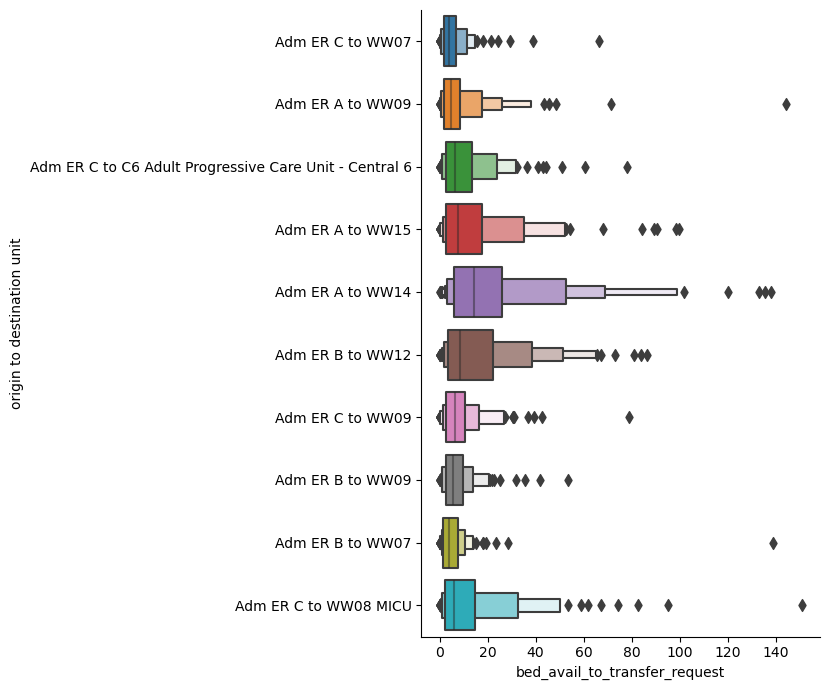

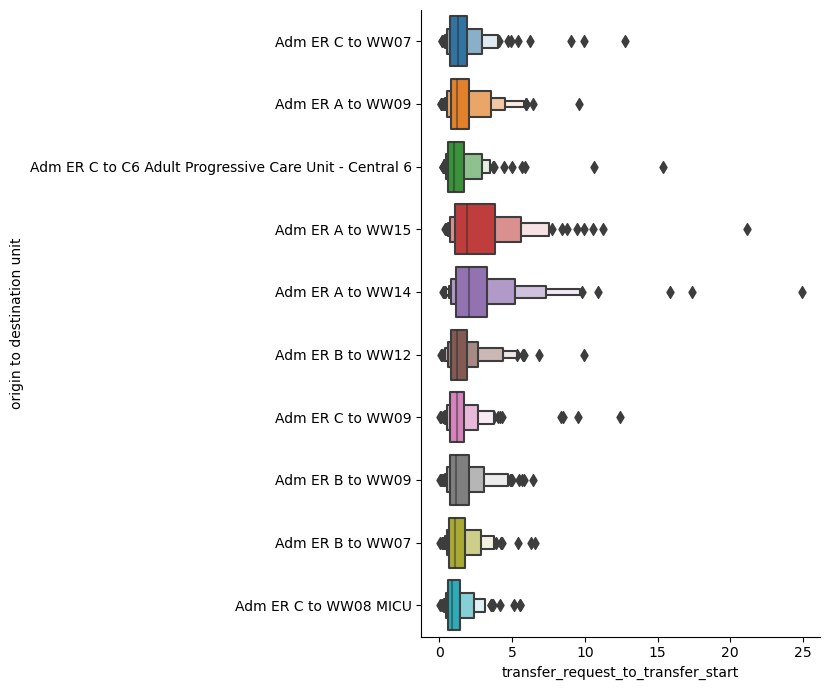

In [85]:
cols =['bed_avail_to_transfer_request', 'transfer_request_to_transfer_start']

for col in cols:
    aggregate_df = aggregate_dataframe(scenario_df, 'origin to destination unit', col)
    top_aggregate = aggregate_df[:10]
    top_10 = top_aggregate['origin to destination unit'].values
    top_10_df = scenario_df[scenario_df['origin to destination unit'].isin(top_10)]
    
    display(top_aggregate)
    
    fig = sns.catplot(data=top_10_df, kind="boxen", 
                       x=col, 
                       y="origin to destination unit",
                       height=7, aspect=1.2) #, height=4, aspect=.6)
    #fig.set_yticklabels()
    #fig.set(xlim=(0,2000))
plt.show()